# Interpretation

## `Class activation map`

`Class activation map` shows which pixels were used by the model to make prediction

---

### Fashion Mnist

In [2]:
import tensorflow as tf
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

#### data

In [2]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

In [3]:
x_train=x_train.reshape(60000,28,28,1)
x_test=x_test.reshape(10000,28,28,1)

x_train=x_train/255
x_test=x_test/255

x_train=x_train.astype(float)
x_test=x_test.astype(float)

#### model

In [6]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,input_shape=(28,28,1),kernel_size=(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10,activation='softmax')
])
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=32,epochs=5,validation_split=0.1,shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 64)        

In [7]:
print(model.layers[-3].name)
print(model.layers[-1].name)

conv2d_9
dense_1


#### subclass model
`CAM model` - class activation map model

In [9]:
can_model=tf.keras.models.Model(inputs=model.input,outputs=[model.layers[-3].output,model.layers[-1].output])
can_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          18496 

#### model weights

In [68]:
last_dense_layer=model.layers[-1]
# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l=last_dense_layer.get_weights()
gap_weights = gap_weights_l[0]
print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)
print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


#### predictions

In [69]:
features,results=can_model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


In [63]:
features.shape

(10000, 3, 3, 128)

In [66]:
results.shape

(10000, 10)

In [120]:
idx=9 # (one of 1000 images) image id should be of the class id
features_for_img=features[idx,:,:,:]
features_for_img.shape

(3, 3, 128)

- `Rescale` features to the image size (from `(3,3)` kernel to the `(28,28)` image)

In [121]:
features_for_img_scaled=sp.ndimage.zoom(features_for_img, (28/3, 28/3,1), order=2)
features_for_img_scaled.shape

(28, 28, 128)

- Get the `weights` for given `class` (class of the image id)

In [122]:
gap_weights.shape

(128, 10)

In [123]:
class_id=7 # (one of 10 classes) lass id should be of the image id
gap_weights_for_one_class = gap_weights[:,class_id]
gap_weights_for_one_class.shape

(128,)

- for each pixel `multipy` the weights of the class with the features values 
  $$ weight \cdot features = cam $$
  $$ (128) \cdot (28 \times 28 \times 128) = (28 \times 28 \times 1) $$
  where cam is as number (product of a sum of features times weight for given class)

In [124]:
cam=np.dot(features_for_img_scaled, gap_weights_for_one_class)
cam.shape

(28, 28)

In [125]:
prediction_class=np.argmax(results[idx])
prediction_class

7

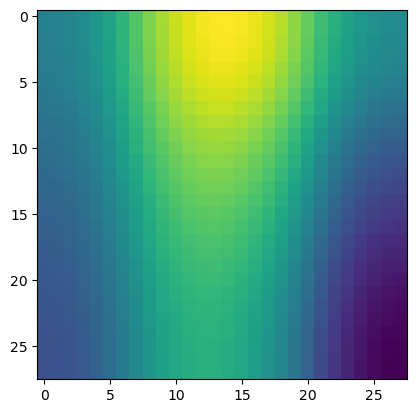

In [126]:
plt.imshow(cam)

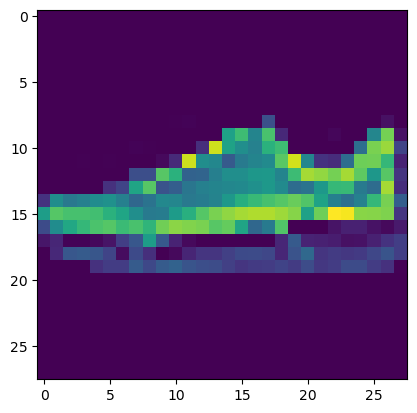

In [127]:
plt.imshow(np.squeeze(x_test[idx],-1))

---

#### visualization

In [28]:
def class_activation_map(image_index):
    features_for_img=features[image_index,:,:,:]
    prediction=np.argmax(results[image_index])
    class_activation_weigths=gap_weights[:,prediction]
    class_activation_features=sp.ndimage.zoom(features_for_img,(28/3,28/3,1),order=2)
    cam_output=np.dot(class_activation_features,class_activation_weigths)
    print(f'Predicted class: {prediction}, Probability: {results[image_index][prediction]}')
    plt.imshow(np.squeeze(x_test[image_index],-1),alpha=0.5)
    if results[image_index][prediction] > 0.95:
        cmap_str='Greens'
    else:
        cmap_str='Reds'
    plt.imshow(cam_output,cmap=cmap_str,alpha=0.5)
    plt.show()

`Dark areas` mean the model `attention is focused` there

Predicted class: 8, Probability: 0.9986045360565186


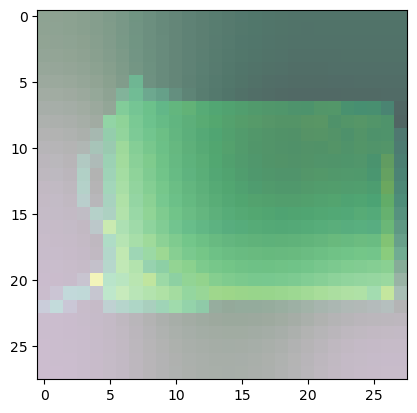

Predicted class: 8, Probability: 0.9999997019767761


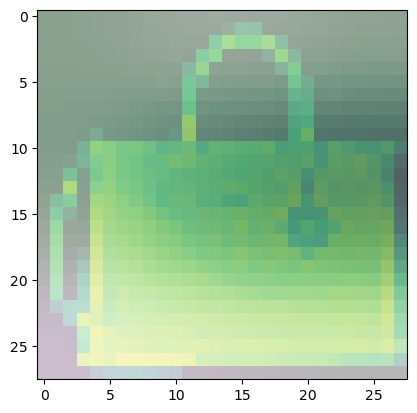

Predicted class: 8, Probability: 0.9986070394515991


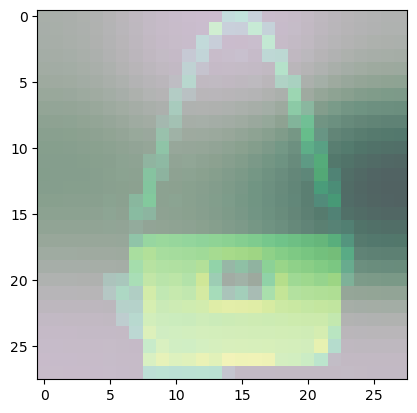

Predicted class: 8, Probability: 0.9999043345451355


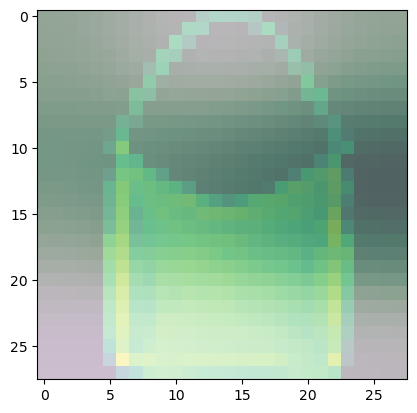

Predicted class: 8, Probability: 0.528018057346344


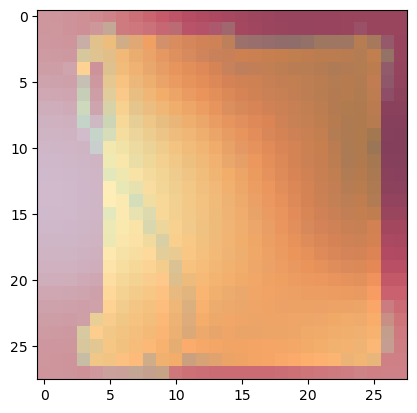

Predicted class: 8, Probability: 0.999680757522583


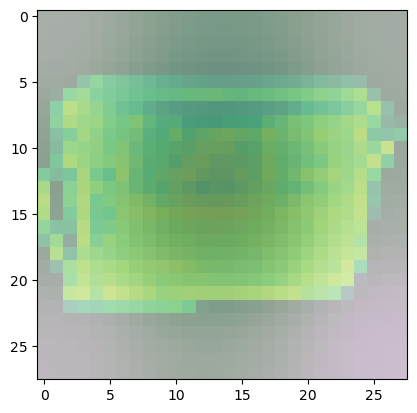

Predicted class: 8, Probability: 0.9978882670402527


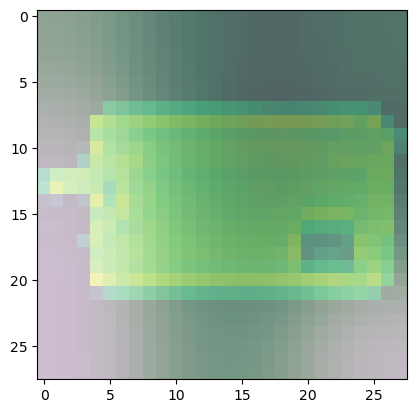

Predicted class: 8, Probability: 0.9998779892921448


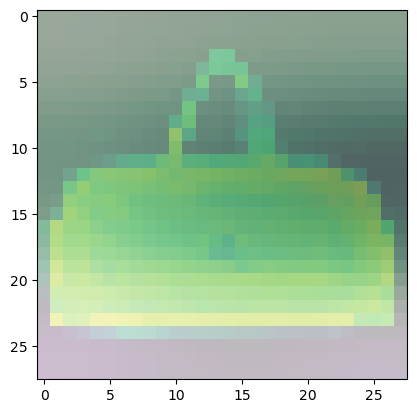

Predicted class: 8, Probability: 0.9999987483024597


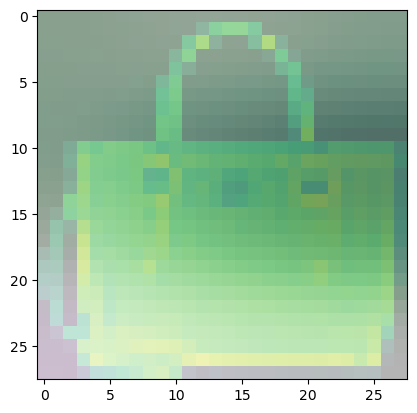

Predicted class: 8, Probability: 0.9990186095237732


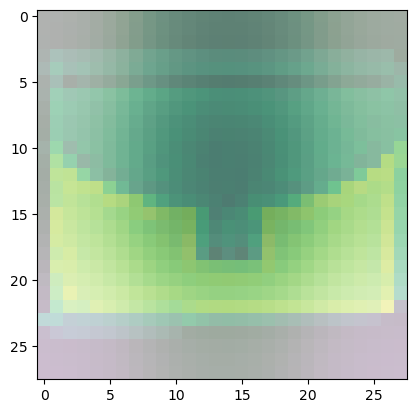

Predicted class: 8, Probability: 0.9998488426208496


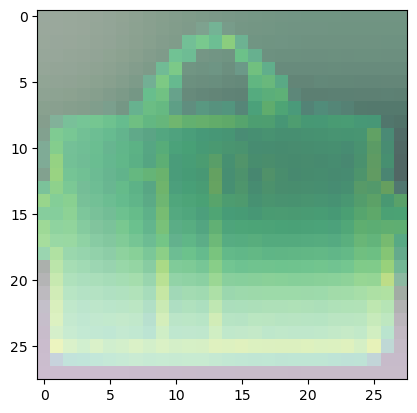

Predicted class: 8, Probability: 0.9945583343505859


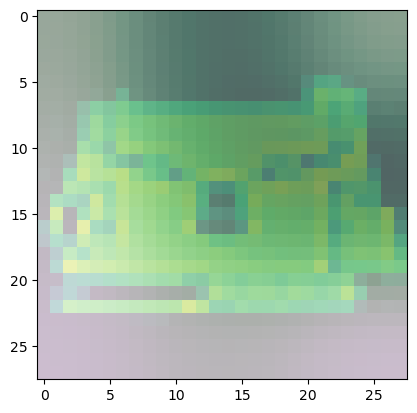

In [29]:
desired_class=8
for i in range(0,100):
    if np.argmax(results[i])==desired_class:
        class_activation_map(i)

---

## Cats vs Dogs

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import tensorflow_hub as hub

#### data

In [8]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

In [7]:
def augment_images(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255)
  image = tf.image.resize(image,(300,300))
  return image, label

augmented_training_data = train_data.map(augment_images)
train_batches = augmented_training_data.shuffle(1024).batch(32)

#### model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(lr=0.001),metrics=['accuracy'])
model.fit(train_batches,epochs=25)

#### model weights

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

#### subclass model

In [ ]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

#### predictions

In [ ]:
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)

In [ ]:
features,results = cam_model.predict(img)

#### visualization

In [9]:
def class_activation_map(image,features, results):
    features_for_img=features[0]
    prediction=results[0]
    class_activation_weigths=gap_weights[:,0]
    class_activation_features=sp.ndimage.zoom(features_for_img,(300/37,300/37,1),order=2)
    cam_output=np.dot(class_activation_features,class_activation_weigths)
    
    print(f'Sigmoid output: {results}')
    print(f"prediction: {'dog' if round(results[0][0]) elsr 'cat'}")
    plt.imshow(cam_output,cmap='jet',alpha=0.5)
    plt.imshow(tf.squeeze(image),alpha=0.5)
    plt.show()

In [ ]:
for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  class_activation_map(img, features, results)

---

In [ ]:
def convert_and_classify(image):
  img = cv2.imread(image)
  img = cv2.resize(img, (300,300)) / 255.0
  tensor_image = np.expand_dims(img, axis=0)
  features,results = cam_model.predict(tensor_image)
  class_activation_map(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')

---

## `Saliency map`

`Saliency map` - reprezentation of every pixel in the image that had an impact on the model prediciton. In contrast to `class activation map` focuses on the `pixels` rather that whole `features`.

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import tensorflow_hub as hub
import cv2

#### model

In [5]:
model = tf.keras.Sequential([hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),tf.keras.layers.Activation('softmax')])
model.build([None, 300, 300, 3])

#### data

In [9]:
img = cv2.imread('image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (300, 300)) / 255.0
image = np.expand_dims(img, axis=0)

In [10]:
class_index=251 #Husky
num_classes=1001
expected_output=tf.one_hot([class_index]*image.shape[0],num_classes)

In contrast to calculation gradient of `loss with respect to the model weights given the input`, we calculate it `with respect to the input given the current weights`.

Therefore `Gradients` tell me which pixels are most important for the model (the bigger gradient value, the more important the pixel).
Later on I just take the absolute value of it and apply math operations to get the final image mask.

In [12]:
with tf.GradientTape() as tape:
    inputs=tf.cast(image,tf.float32)
    tape.watch(inputs)
    predictions=model(inputs)
    loss=tf.keras.losses.categorical_crossentropy(expected_output,predictions)
gradients=tape.gradient(loss,inputs)

In [14]:
grayscale_tensor=tf.reduce_sum(tf.abs(gradients),axis=-1)
normalized_tensor=tf.cast(255*(grayscale_tensor-tf.reduce_min(grayscale_tensor))/(tf.reduce_max(grayscale_tensor)-tf.reduce_min(grayscale_tensor)),tf.uint8)
normalized_tensor=tf.squeeze(normalized_tensor)

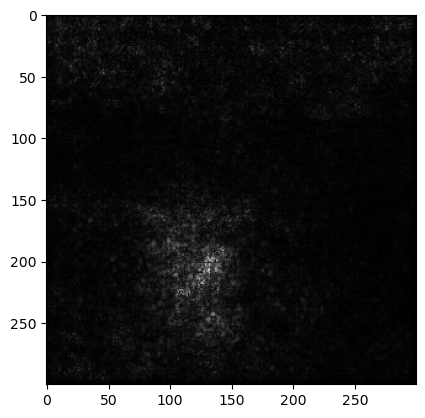

In [17]:
plt.imshow(normalized_tensor,cmap='gray')

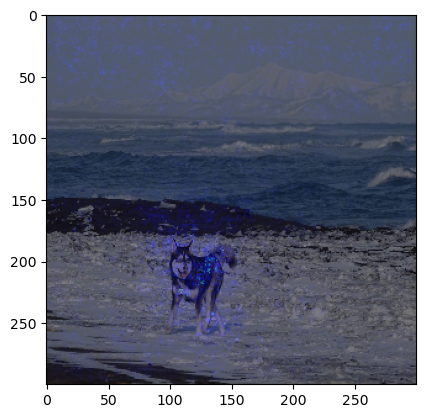

In [19]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.imshow(super_imposed)

---

## GradCAM model

`GradCAM` - Gradient weighted Class Activation Mapping -  model uses both approaches (`Class Activation Map` and `Saliency`) combined. It's a `Class Activation Map` that uses the `gradients of the final classifications`.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import tensorflow_hub as hub
import cv2

C:\Users\pk764\miniconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_CAM(image,pred_label,layer_name):
    model_grad=Model([model.inouts],[model.get_layer(layer_name).output,model.output])
    with tf.GradientTape() as tape:
        conv_output_values,predictions=model_grad(image)
        loss=predictions[:,pred_label]
        grads_values=tape.gradient(loss, conv_output_values)
        grads_values=K.mean(grads_values,axis=(0,1,2))
        conv_output_values=np.squeeze(conv_output_values.numpy())
        grads_values=grads_values.numpy()

        for i in range(512):
            conv_output_values[:,:,i]*=grads_values[i]

        heatmap=np.mean(conv_output_values,axis=1)
        heatmap=np. maximum(heatmap,0)
        heatmap/=heatmap.max()
        del model_grad, conv_output_values,grads_values,loss

        return heatmap